In [8]:
from pathlib import Path

import pandas as pd
import datashader as ds
import datashader.transfer_functions as tf
import datashader.bundling as bd
import matplotlib.pyplot as plt
import colorcet
import matplotlib.colors
import matplotlib.cm

import bokeh.plotting as bpl
import bokeh.transform as btr
import holoviews as hv
import holoviews.operation.datashader as hd

In [9]:
import re
import scipy
import functools
import numpy as np

import networkx as nx

from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem, rdFingerprintGenerator, MACCSkeys
from rdkit.DataStructs import TanimotoSimilarity
from rdkit.Chem.Fingerprints import FingerprintMols

import matplotlib.pyplot as plt
%matplotlib inline

import umap
import umap.plot

from tqdm.notebook import tqdm

In [10]:
from sklearn.cluster import HDBSCAN
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.utils import check_X_y
from sklearn.utils import _safe_indexing
from sklearn.utils import check_random_state
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import pairwise_distances_chunked
from sklearn.utils.validation import _deprecate_positional_args

In [11]:
HERE = Path.cwd()
DATA = HERE / "data"

In [12]:
def check_number_of_labels(n_labels, n_samples):
    if not 1 < n_labels < n_samples:
        raise ValueError("Number of labels is %d. Valid values are 2"
                         "to n_samples - 1 (inclusive)" % n_labels)


def FingerprintFromSmiles(smiles, method='morgan'):
    """Converts SMILES to Fingerprint"""

    if method == "rdkit":
        rdk_fpg = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
        return rdk_fpg.GetFingerprint(Chem.MolFromSmiles(smiles))
    elif method == "morgan":
        mfp_fpg = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)
        return mfp_fpg.GetFingerprint(Chem.MolFromSmiles(smiles))
    elif method == "maccs":
        return MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(smiles))
    else:
        return "invalid method: use rdkit or morgan"

In [13]:
zinc_data_f = pd.read_csv(DATA / "filtered_zinc_data.csv")
# data_r = pd.read_csv("")

print(zinc_data_f.shape)
zinc_data_f.head()

(486318, 6)


,smiles,zinc_id,inchikey,mwt,logp,reactive
0,Cc1cc(C(=O)O)nn1C(C)(C)C,128082,FCFGJNOOQYQMKY-UHFFFAOYSA-N,182.223,1.645,0
1,Cc1cc(C=O)oc1C,153224,JPTPEPVCVXGNJM-UHFFFAOYSA-N,124.139,1.709,0
2,Oc1nc2ccc(Cl)cc2nc1O,336490,RNOLFZACEWWIHP-UHFFFAOYSA-N,196.593,1.694,0
3,CC(C)[C@@H]1C(=O)C[C@@H](C)CN1C,1296142,ALCOISCHVBFFNS-PSASIEDQSA-N,169.268,1.552,0
4,COc1cc(N(C)C)ccc1C=O,1583074,HGDRXADJVGVGBC-UHFFFAOYSA-N,179.219,1.574,0


Add ROMol objects of these molecules to the DataFrame.

Calculate circular **Morgan fingerprints** for molecules and add those values to a DataFrame as a separate column named morgan_fp.

In [14]:
zinc_data_f["morgan_fp"] = [FingerprintFromSmiles(smiles, method='morgan') for smiles in tqdm(zinc_data_f["smiles"], desc="Generating Morgan fingerprints for zinc_data")]

print(zinc_data_f.shape)
zinc_data_f.head(5)

Generating Morgan fingerprints for zinc_data:   0%|          | 0/486318 [00:00<?, ?it/s]

(486318, 7)


,smiles,zinc_id,inchikey,mwt,logp,reactive,morgan_fp
0,Cc1cc(C(=O)O)nn1C(C)(C)C,128082,FCFGJNOOQYQMKY-UHFFFAOYSA-N,182.223,1.645,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Cc1cc(C=O)oc1C,153224,JPTPEPVCVXGNJM-UHFFFAOYSA-N,124.139,1.709,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Oc1nc2ccc(Cl)cc2nc1O,336490,RNOLFZACEWWIHP-UHFFFAOYSA-N,196.593,1.694,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,CC(C)[C@@H]1C(=O)C[C@@H](C)CN1C,1296142,ALCOISCHVBFFNS-PSASIEDQSA-N,169.268,1.552,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,COc1cc(N(C)C)ccc1C=O,1583074,HGDRXADJVGVGBC-UHFFFAOYSA-N,179.219,1.574,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


Create **RDKit fingerprints** for all molecules and add the values to a DataFrame as a separate column named rdkit_fp.

In [15]:
zinc_data_f["rdkit_fp"] = [FingerprintFromSmiles(smiles, method='rdkit') for smiles in tqdm(zinc_data_f["smiles"], desc="Generating RDKit fingerprints for zinc_data")]

print(zinc_data_f.shape)
zinc_data_f.head(5)

Generating RDKit fingerprints for zinc_data:   0%|          | 0/486318 [00:00<?, ?it/s]

(486318, 8)


,smiles,zinc_id,inchikey,mwt,logp,reactive,morgan_fp,rdkit_fp
0,Cc1cc(C(=O)O)nn1C(C)(C)C,128082,FCFGJNOOQYQMKY-UHFFFAOYSA-N,182.223,1.645,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Cc1cc(C=O)oc1C,153224,JPTPEPVCVXGNJM-UHFFFAOYSA-N,124.139,1.709,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Oc1nc2ccc(Cl)cc2nc1O,336490,RNOLFZACEWWIHP-UHFFFAOYSA-N,196.593,1.694,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
3,CC(C)[C@@H]1C(=O)C[C@@H](C)CN1C,1296142,ALCOISCHVBFFNS-PSASIEDQSA-N,169.268,1.552,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,COc1cc(N(C)C)ccc1C=O,1583074,HGDRXADJVGVGBC-UHFFFAOYSA-N,179.219,1.574,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


**Tanimoto similarity and distance matrix**

Define function to calculate Tanimoto similarity and distance matrix.

In [21]:
def tanimoto_distance_matrix(fp_list):
    """Calculate distance matrix for fingerprint list"""
    dissimilarity_matrix = []
    # We are deliberately skipping the first and last items in the list
    # because we don't need to compare them against themselves
    for i in tqdm(range(1, len(fp_list)), desc="Calculating Tanimoto distance matrix"):
        # Compare the current fingerprint against all the previous ones in the list
        similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i], fp_list[:i])
        # Since we need a distance matrix, calculate 1-x for every element in similarity matrix
        dissimilarity_matrix.extend([1 - x for x in similarities])
    return dissimilarity_matrix

Separate Morgan fingerprints from the DataFrame.

Since the DataFrame is too large let's separate the first 1000 molecules.

In [35]:
df_first_1000 = zinc_data_f.iloc[:1000].copy()
mfps = df_first_1000["morgan_fp"]

In [36]:
# Example: Calculate single similarity of two fingerprints
# NBVAL_CHECK_OUTPUT
sim = DataStructs.TanimotoSimilarity(mfps[0], mfps[1])
print(f"Tanimoto similarity: {sim:.2f}, distance: {1-sim:.2f}")

Tanimoto similarity: 0.15, distance: 0.85


In [37]:
# Example: Calculate distance matrix (distance = 1-similarity)
tanimoto_distance_matrix(mfps)[0:5]

Calculating Tanimoto distance matrix:   0%|          | 0/999 [00:00<?, ?it/s]

[0.85,
 0.8809523809523809,
 0.9210526315789473,
 0.9130434782608696,
 0.926829268292683]

In [38]:
mfps_list = list(mfps)

dist_array = np.eye(len(mfps_list))
for c, f in enumerate(mfps_list):
    dist_array[c, c + 1:] = DataStructs.BulkTanimotoSimilarity(f, mfps_list[c + 1:])
T = np.maximum(dist_array, dist_array.transpose())

In [39]:
T

array([[1.        , 0.15      , 0.11904762, ..., 0.11627907, 0.13043478,
        0.0952381 ],
       [0.15      , 1.        , 0.07894737, ..., 0.05      , 0.06976744,
        0.05263158],
       [0.11904762, 0.07894737, 1.        , ..., 0.02380952, 0.02173913,
        0.05128205],
       ...,
       [0.11627907, 0.05      , 0.02380952, ..., 1.        , 0.23076923,
        0.13513514],
       [0.13043478, 0.06976744, 0.02173913, ..., 0.23076923, 1.        ,
        0.17948718],
       [0.0952381 , 0.05263158, 0.05128205, ..., 0.13513514, 0.17948718,
        1.        ]], shape=(1000, 1000))

In [40]:
adjacency_mask = T >= 0.8
nb_clusters, labels = scipy.sparse.csgraph.connected_components(adjacency_mask)

In [41]:
df_first_1000['Cluster ID'] = labels
top_15_clusters = df_first_1000['Cluster ID'].value_counts().head(15).index
df_first_1000['Cluster ID scipy'] = df_first_1000['Cluster ID'].apply(lambda x: x if x in top_15_clusters else -1)

In [42]:
df_first_1000.head()

,smiles,zinc_id,inchikey,mwt,logp,reactive,morgan_fp,rdkit_fp,Cluster ID,Cluster ID scipy
0,Cc1cc(C(=O)O)nn1C(C)(C)C,128082,FCFGJNOOQYQMKY-UHFFFAOYSA-N,182.223,1.645,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,-1
1,Cc1cc(C=O)oc1C,153224,JPTPEPVCVXGNJM-UHFFFAOYSA-N,124.139,1.709,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,-1
2,Oc1nc2ccc(Cl)cc2nc1O,336490,RNOLFZACEWWIHP-UHFFFAOYSA-N,196.593,1.694,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",2,-1
3,CC(C)[C@@H]1C(=O)C[C@@H](C)CN1C,1296142,ALCOISCHVBFFNS-PSASIEDQSA-N,169.268,1.552,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3,-1
4,COc1cc(N(C)C)ccc1C=O,1583074,HGDRXADJVGVGBC-UHFFFAOYSA-N,179.219,1.574,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4,4


In [44]:
smiles_list = list(df_first_1000['smiles'].to_list())
vectors = np.array([[int(i) for i in FingerprintFromSmiles(s,).ToBitString()] for s in smiles_list])

C:\Users\hrach\Desktop\Denovo Sciences\Hamlet Meetings\Task2_Compound_Clustering\.venv\Lib\site-packages\umap\umap_.py:1887: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


<Axes: >

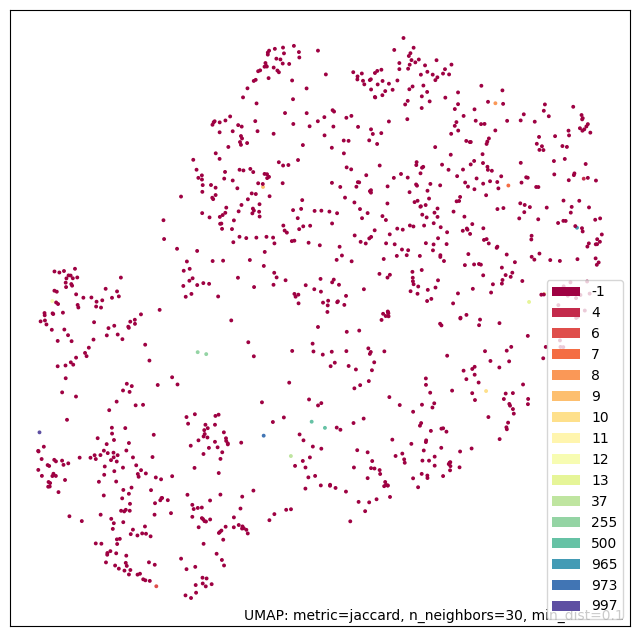

In [45]:
mapper = umap.UMAP(metric='jaccard', low_memory=True, n_neighbors=30, min_dist=0.1).fit(vectors)
umap.plot.points(mapper, labels=df_first_1000['Cluster ID scipy'])

In [46]:
a = 0.8

clustering_H = HDBSCAN(metric='precomputed',min_cluster_size=20,min_samples=10,
                               cluster_selection_epsilon=0., cluster_selection_method='eom')
labels_H = clustering_H.fit_predict(1-T)
n_clusters_ = len(set(labels_H)) - (1 if -1 in labels_H else 0)

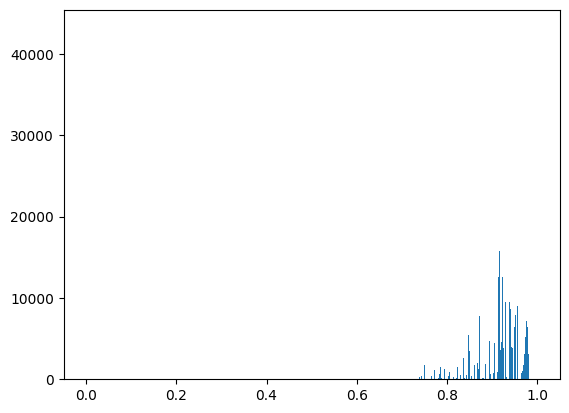

In [47]:
plt.hist((1-T).flatten(),bins=2000)
plt.show()

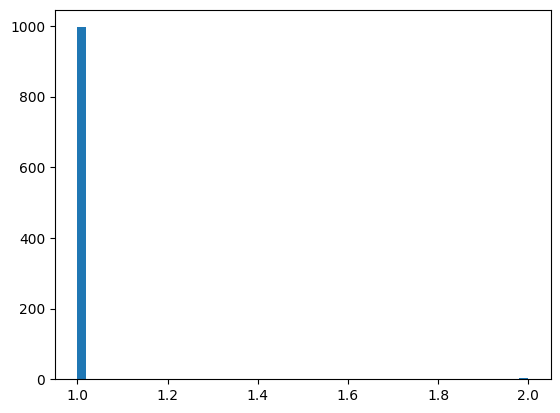

In [48]:
plt.hist(((1-T)<0.2).sum(axis=0),bins=50)
plt.show()

In [49]:
((1-T)<0.2).sum(axis=0)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [50]:
df_first_1000['Cluster ID'] = labels_H
df_first_1000['Cluster ID'].value_counts()
df_first_1000['Cluster ID'].value_counts()

Cluster ID
 1    475
-1    450
 2     50
 0     25
Name: count, dtype: int64

In [51]:
fig = plt.figure(figsize = (16,8))

clustering_H.condensed_tree_.plot(select_clusters=True)
plt.show()

AttributeError: 'HDBSCAN' object has no attribute 'condensed_tree_'

<Figure size 1600x800 with 0 Axes>

C:\Users\hrach\Desktop\Denovo Sciences\Hamlet Meetings\Task2_Compound_Clustering\.venv\Lib\site-packages\umap\umap_.py:1887: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


<Axes: >

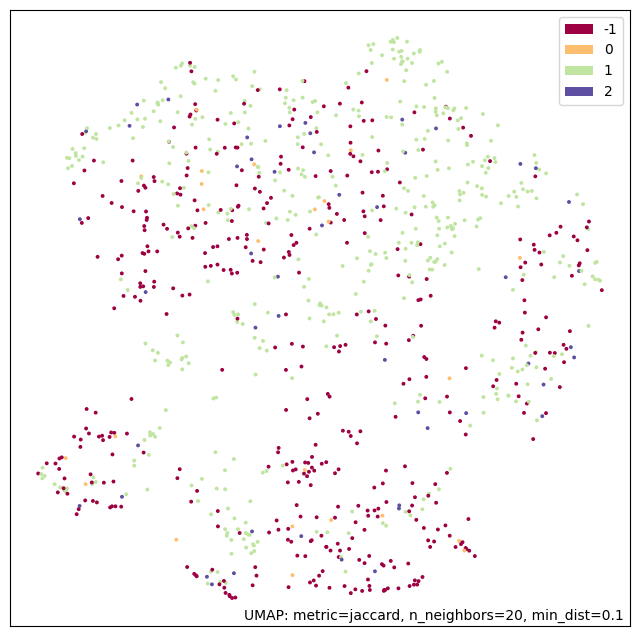

In [52]:
mapper = umap.UMAP(metric='jaccard', low_memory=True, n_neighbors=20, min_dist=0.1).fit(vectors)
umap.plot.points(mapper, labels=df_first_1000['Cluster ID'])

In [54]:
df_first_1000['umap0'] = mapper.embedding_.T[0]
df_first_1000['umap1'] = mapper.embedding_.T[1]
data_sorted = df_first_1000.sort_values('Energy')
plt.figure(figsize=(16,8))
plt.scatter(data_sorted['umap0'],data_sorted['umap1'],s=8,c=data_sorted['Reward'], cmap='cool')
plt.colorbar()
plt.show()

KeyError: 'Reward'

<Figure size 1600x800 with 0 Axes>